In [34]:
from typing import *
import os
import random
from enum import Enum
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from IPython.display import display


sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義

# Epsilon-Greedy 法

In [35]:
State = int
Action = int

class CoinToss:
    def __init__(self, head_probs: List[float], max_episode_steps: int = 30) -> None:
        self.head_probs : List[float] = head_probs
        self.max_episode_steps : int = max_episode_steps
        self.toss_count : int = 0

    def __len__(self) -> int:
        return len(self.head_probs)

    def reset(self):
        self.toss_count = 0

    def step(self, action: Action) -> Tuple[float, bool]:
        final : int = self.max_episode_steps - 1
        if self.toss_count < final:
            done : bool = False
        elif self.toss_count == final:
            done : bool = True
        else:
            raise Exception('The step count exceeded maximum. Please reset env.')
        
        if action >= len(self.head_probs):
            raise Exception(f'The No. {action} coin doesn\'t exist.')
        else:
            head_prob : float = self.head_probs[action]
            if random.random() < head_prob:
                reward : float = 1.0
            else:
                reward : float = 0.0
            self.toss_count += 1
            return reward, done


class EpsilonGreedyAgent:
    def __init__(self, epsilon: float) -> None:
        self.epsilon : float = epsilon
        self.V : List[float] = []
    
    def policy(self) -> Action:
        coins : List[int] = list(range(len(self.V)))
        if random.random() < self.epsilon:
            return random.choice(coins)  # 探索
        return np.argmax(self.V)  # 活用

    def play(self, env: CoinToss) -> List[float]:
        N : List[int] = [0] * len(env)  #  各コインが投げられた回数を保存するlist
        self.V = [0] * len(env)

        env.reset()
        done : bool = False
        rewards : List[float] = []
        while not done:
            selected_coin : Action = self.policy()
            reward, done = env.step(action=selected_coin)
            rewards.append(reward)

            n : int = N[selected_coin]
            coin_average : float = self.V[selected_coin]
            new_average : float = (coin_average * n + reward) / (n + 1)
            N[selected_coin] += 1
            self.V[selected_coin] = new_average
        
        return rewards

<AxesSubplot:xlabel='coin toss count'>

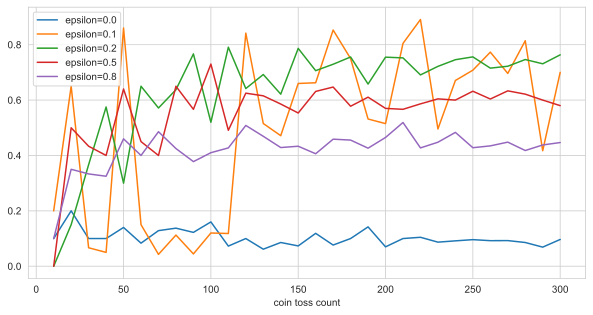

In [36]:
env = CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])
epsilons = [0.0, 0.1, 0.2, 0.5, 0.8]
game_steps = list(range(10, 310, 10))
result = {}
for e in epsilons:
    agent = EpsilonGreedyAgent(epsilon=e)
    means = []
    for s in game_steps:
        env.max_episode_steps = s
        rewards = agent.play(env)
        means.append(np.mean(rewards))
    result["epsilon={}".format(e)] = means
result["coin toss count"] = game_steps
result = pd.DataFrame(result)
result.set_index("coin toss count", drop=True, inplace=True)
result.plot.line(figsize=(10, 5))

# Monte Carlo vs. Temporal Difference

In [62]:
State = int
Action = int

class ELAgent:
    def __init__(self, epsilon: float) -> None:
        self.Q : Dict[State, List[Action]] = {}
        self.epsilon : float = epsilon
        self.reward_log : List[float] = []

    def policy(self, s: State, actions: List[Action]) -> Action:
        if np.random.random() < self.epsilon:
            return np.random.randint(len(actions))
        if (s in self.Q) and (sum(self.Q[s]) != 0):
            return np.argmax(self.Q[s])
        return np.random.randint(len(actions))

    def init_log(self) -> None:
        self.reward_log = []

    def log(self, reward: float) -> None:
        self.reward_log.append(reward)

    def show_reward_log(self, interval: int = 50, episode: int = -1) -> None:
        if episode > 0:
            rewards : List[float] = self.reward_log[-interval:]
            mean : float = np.round(np.mean(rewards), 3)
            std : float = np.round(np.std(rewards), 3)
            print(f'At Episode {episode} average reward is {mean} (+/- {std}).')
        else:
            indices : List[int] = list(range(0, len(self.reward_log), interval))
            means : List[float] = []
            stds : List[float] = []
            for i in indices:
                rewards : List[float] = self.reward_log[i:(i+interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            means : NDArray[float] = np.array(means)
            stds : NDArray[float] = np.array(stds)
            plt.figure()
            plt.title("Reward History")
            plt.fill_between(indices, means - stds, means + stds, alpha=0.1, color="g")
            plt.plot(indices, means, "o-", color="g", label="Rewards for each {} episode".format(interval))
            plt.legend(loc="best")
            plt.show()

In [63]:
import gym

Env = gym.wrappers.time_limit.TimeLimit  # 型宣言

def show_q_value(Q: Dict[State, List[Action]]) -> None:
    """行動価値を可視化する"""
    env : Env = gym.make('FrozenLake-v1')
    nrow : int = env.unwrapped.nrow
    ncol : int = env.unwrapped.ncol
    state_size : int = 3
    q_nrow : int = nrow * state_size
    q_ncol : int = ncol * state_size
    reward_map : NDArray[(q_nrow, q_ncol), float] = np.zeros((q_ncol, q_ncol))

    for r in range(nrow):
        for c in range(ncol):
            s : int = r * ncol + c
            state_exist : bool = False
            if isinstance(Q, dict) and (s in Q):
                state_exist = True
            elif isinstance(Q, (np.ndarray, np.generic)) and s < Q.shape[0]:
                state_exist = True
            
            if state_exist:
                # At the display map, the vertical index is reversed.
                _r = 1 + (nrow - 1 - r) * state_size
                _c = 1 + c * state_size
                reward_map[_r][_c - 1] = Q[s][0]  # LEFT = 0
                reward_map[_r - 1][_c] = Q[s][1]  # DOWN = 1
                reward_map[_r][_c + 1] = Q[s][2]  # RIGHT = 2
                reward_map[_r + 1][_c] = Q[s][3]  # UP = 3
                reward_map[_r][_c] = np.mean(Q[s])  # Center

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(reward_map, cmap=cmap, interpolation="bilinear", vmax=abs(reward_map).max(), vmin=-abs(reward_map).max())
    ax.set_xlim(-0.5, q_ncol - 0.5)
    ax.set_ylim(-0.5, q_nrow - 0.5)
    ax.set_xticks(np.arange(-0.5, q_ncol, state_size))
    ax.set_yticks(np.arange(-0.5, q_nrow, state_size))
    ax.set_xticklabels(range(ncol + 1))
    ax.set_yticklabels(range(nrow + 1))
    plt.show()

## Monte Carlo法

At Episode 50 average reward is 0.0 (+/- 0.0).
At Episode 100 average reward is 0.3 (+/- 0.458).
At Episode 150 average reward is 0.92 (+/- 0.271).
At Episode 200 average reward is 0.92 (+/- 0.271).
At Episode 250 average reward is 0.9 (+/- 0.3).
At Episode 300 average reward is 0.88 (+/- 0.325).
At Episode 350 average reward is 0.84 (+/- 0.367).
At Episode 400 average reward is 0.94 (+/- 0.237).
At Episode 450 average reward is 0.96 (+/- 0.196).


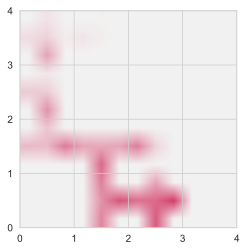

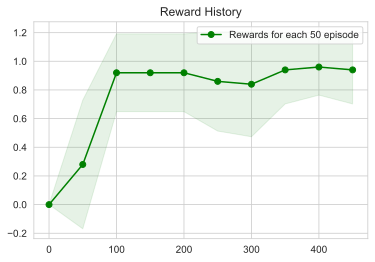

In [66]:
import math
from collections import defaultdict


class MonteCarloAgent(ELAgent):
    def __init__(self, epsilon: float = 0.1) -> None:
        super().__init__(epsilon)

    def learn(self, env: Env, episode_count: int = 1000, gamma: float = 0.9, render: bool = False, report_interval: int = 50) -> None:
        self.init_log()
        actions : List[Action] = list(range(env.action_space.n))
        self.Q : Dict[State, List[Action]] = defaultdict(lambda: [0] * len(actions))
        N : Dict[State, List[Action]] = defaultdict(lambda: [0] * len(actions))  # N[s][a]: 状態sで行動aをとった回数

        for e in range(episode_count):
            s : State = env.reset()
            done : bool = False
            # Play until the end of episode.
            experience : List[str, Union[State, Action, float]] = []
            while not done:
                if render:
                    env.render()  # 環境の表示
                a : Action = self.policy(s=s, actions=actions) 
                n_state, reward, done, _ = env.step(a)
                experience.append({'state': s, 'action': a, 'reward': reward})
                s = n_state
            else:
                self.log(reward=reward)
            
            # Evaluate each state, action.
            for i, x in enumerate(experience):
                s, a = x['state'], x['action']
                # Calculate discounted future reward of s.
                G, t = 0, 0
                for j in range(i, len(experience)):
                    G += math.pow(gamma, t) * experience[j]['reward']
                    t += 1
                
                N[s][a] += 1  # cont of s, a pair
                alpha = 1 / N[s][a]
                self.Q[s][a] += alpha * (G - self.Q[s][a])
            
            if e != 0 and e % report_interval == 0:
                self.show_reward_log(episode=e)


def train() -> None:
    agent = MonteCarloAgent(epsilon=0.1)
    env = gym.make('FrozenLakeEasy-v0')
    agent.learn(env, episode_count=500)
    show_q_value(agent.Q)
    agent.show_reward_log()


train()

## TD法 ~ Q-learning ~